In [10]:
#import
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#Defining base directory
base_dir = "/Users/kelly/Downloads/iLab-Capstone/data/WESAD"

subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

target_hz = 4

for sid in subjects:
    p = os.path.join(base_dir, sid, f"{sid}.pkl")
    print(f"{sid}: {'OK' if os.path.exists(p) else 'MISSING'}  ->  {p}")

S2: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S2/S2.pkl
S3: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S3/S3.pkl
S4: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S4/S4.pkl
S5: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S5/S5.pkl
S6: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S6/S6.pkl
S7: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S7/S7.pkl
S8: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S8/S8.pkl
S9: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S9/S9.pkl
S10: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S10/S10.pkl
S11: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S11/S11.pkl
S13: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S13/S13.pkl
S14: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S14/S14.pkl
S15: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S15/S15.pkl
S16: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S16/S16.pkl
S1

In [12]:
def safe_get_signal(entry):
    """Return np.ndarray for either dict-with-'signal' or raw array/list."""
    if isinstance(entry, dict) and "signal" in entry:
        return np.asarray(entry["signal"])
    return np.asarray(entry)

def to_series(arr, name):
    """Flatten to 1-D Series with a RangeIndex (we'll attach time later)."""
    return pd.Series(np.asarray(arr).squeeze(), name=name)

def seconds_index(n, fs):
    """Create a time index in seconds for n samples at sampling rate fs."""
    return pd.to_timedelta(np.arange(n) / float(fs), unit="s")

def extract_chest_df(data):
    ch = data["signal"]["chest"]
    # read with shape-proof helper and flatten
    C_RESP = to_series(safe_get_signal(ch["Resp"]), "C_RESP")
    C_ECG  = to_series(safe_get_signal(ch["ECG"]) , "C_ECG")
    C_EDA  = to_series(safe_get_signal(ch["EDA"]) , "C_EDA")
    C_EMG  = to_series(safe_get_signal(ch["EMG"]) , "C_EMG")
    # Temp key casing varies; handle both
    temp_key = "Temp" if "Temp" in ch else ("TEMP" if "TEMP" in ch else None)
    C_TEMP = to_series(safe_get_signal(ch[temp_key]), "C_TEMP") if temp_key else None

    # Chest native fs ~700 Hz (use 700 if not present)
    fs = ch["Resp"].get("sampling_rate", 700) if isinstance(ch["Resp"], dict) else 700
    # build DataFrame with a proper time index (seconds)
    cols = [C_RESP, C_ECG, C_EDA, C_EMG] + ([C_TEMP] if C_TEMP is not None else [])
    chest = pd.concat(cols, axis=1)
    chest.index = seconds_index(len(chest), fs)
    return chest

def extract_wrist_df(data):
    wr = data["signal"]["wrist"]

    W_BVP  = to_series(safe_get_signal(wr["BVP"]), "W_BVP")
    W_EDA  = to_series(safe_get_signal(wr["EDA"]), "W_EDA")
    temp_key = "TEMP" if "TEMP" in wr else ("Temp" if "Temp" in wr else None)
    W_TEMP = to_series(safe_get_signal(wr[temp_key]), "W_TEMP") if temp_key else None

    # ACC can be (n,3), (3,n), (n,1*3) … normalize to 3 separate 1-D series
    acc = safe_get_signal(wr["ACC"])
    acc = np.squeeze(acc)
    if acc.ndim == 2:
        if acc.shape[0] == 3 and acc.shape[1] != 3:
            acc = acc.T
        if acc.shape[1] >= 3:
            W_ACC_X = to_series(acc[:,0], "W_ACC_X")
            W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
            W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
        else:
            # unusual; fall back to single column
            W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
            W_ACC_Y = W_ACC_Z = None
    elif acc.ndim == 1 and acc.size % 3 == 0:
        acc = acc.reshape(-1, 3)
        W_ACC_X = to_series(acc[:,0], "W_ACC_X")
        W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
        W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
    else:
        W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
        W_ACC_Y = W_ACC_Z = None

    # Wrist fs ~64 Hz; if present, use it from any channel
    fs = 64
    for k in ("BVP","EDA","TEMP","Temp","ACC"):
        if k in wr and isinstance(wr[k], dict) and "sampling_rate" in wr[k]:
            fs = wr[k]["sampling_rate"]; break

    cols = [W_BVP, W_EDA] + ([W_TEMP] if W_TEMP is not None else []) + \
           [W_ACC_X] + ([W_ACC_Y] if W_ACC_Y is not None else []) + ([W_ACC_Z] if W_ACC_Z is not None else [])
    wrist = pd.concat(cols, axis=1)
    wrist.index = seconds_index(len(wrist), fs)
    return wrist

def labels_series(data, fs_guess=700):
    y = np.asarray(data["label"]).squeeze()
    s = to_series(y, "Label")
    s.index = seconds_index(len(s), fs_guess)  # align roughly to chest clock
    return s.astype(int)

def resample_to(df, hz):
    """Downsample any time-indexed DF to target Hz using mean aggregation."""
    # ensure TimedeltaIndex then resample
    df = df.copy()
    df = df.resample(pd.to_timedelta(1/hz, unit="s")).mean()
    return df

def resample_labels(y, hz):
    """Downsample labels to target Hz using mode aggregation."""
    y = y.copy()
    y = y.resample(pd.to_timedelta(1/hz, unit="s")).agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else np.nan
    )
    return y.astype(int)

def load_subject_4hz(subject_id):
    pkl_path = os.path.join(base_dir, subject_id, f"{subject_id}.pkl")
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    chest = extract_chest_df(data)
    wrist = extract_wrist_df(data)
    y     = labels_series(data, fs_guess=700)     # labels aligned to chest clock

    # resample everything to the same 4 Hz grid
    chest_4 = resample_to(chest, target_hz)
    wrist_4 = resample_to(wrist, target_hz)
    y_4     = resample_labels(y.to_frame(), target_hz)

    # inner-join on common timestamps to guarantee equal lengths
    df4 = chest_4.join(wrist_4, how="inner").join(y_4, how="inner")
    df4["subject_id"] = subject_id
    return df4

#  LOAD ALL SUBJECTS 
dfs = []
for sid in subjects:
    try:
        df4 = load_subject_4hz(sid)
        print(f"✔ {sid}: {df4.shape}")
        dfs.append(df4)
    except Exception as e:
        print(f"✖ {sid}: {type(e).__name__} — {e}")

if not dfs:
    raise RuntimeError("No subjects loaded — check BASE_DIR or error messages above.")

combined_df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", combined_df.shape)
combined_df.head()

✔ S2: (24316, 13)
✔ S3: (25972, 13)
✔ S4: (25692, 13)
✔ S5: (25032, 13)
✔ S6: (28284, 13)
✔ S7: (20952, 13)
✔ S8: (21864, 13)
✔ S9: (20892, 13)
✔ S10: (21984, 13)
✔ S11: (20932, 13)
✔ S13: (22148, 13)
✔ S14: (22192, 13)
✔ S15: (21008, 13)
✔ S16: (22524, 13)
✔ S17: (23680, 13)
Combined shape: (347472, 13)


,C_RESP,C_ECG,C_EDA,C_EMG,C_TEMP,W_BVP,W_EDA,W_TEMP,W_ACC_X,W_ACC_Y,W_ACC_Z,Label,subject_id
0,-1.175258,0.099215,5.250514,-0.003072,30.130919,6.269375,1.105996,35.410,57.7500,15.5625,21.875,0,S2
1,-0.849400,-0.144645,5.245671,-0.001752,30.123537,45.905000,1.176838,35.420,46.6250,11.5625,37.875,0,S2
2,-0.449097,0.033754,5.242846,-0.002758,30.122858,54.358750,1.085223,35.435,58.2500,19.0000,19.125,0,S2
3,-0.295279,0.067728,5.240734,-0.001257,30.117262,21.695625,1.119098,35.420,53.2500,16.6250,30.000,0,S2
4,-0.222866,-0.187926,5.257104,-0.003136,30.109482,-209.836875,1.284150,35.440,54.0625,23.2500,20.750,0,S2


In [13]:
combined_df['Label'].unique()

array([0, 1, 2, 6, 4, 3, 7, 5])

In [19]:
import sys
!{sys.executable} -m pip install "xgboost==2.0.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [20]:
#Import for modelling
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
from xgboost import XGBClassifier
import optuna

In [32]:
# Copy dataset
df = combined_df.copy()
df["Label"] = df["Label"].astype(int)

# Feature groups (numeric only is safest)
FEATURES   = [c for c in df.columns if c not in ("Label","subject_id")]
WRIST_COLS = [c for c in df.columns if str(c).startswith("W_")]
CHEST_COLS = [c for c in df.columns if str(c).startswith("C_")]

# Rows we use (same rows for 3-class and binary)
m = df["Label"].isin([1,2,3]).values

# ---------- Multiclass (remap 1,2,3 -> 0,1,2) ----------
label_map_3_to_012 = {1:0, 2:1, 3:2}
y3 = df.loc[m, "Label"].map(label_map_3_to_012).to_numpy(dtype=int)
g3 = df.loc[m, "subject_id"].to_numpy(str)

X3_full  = df.loc[m, FEATURES].to_numpy(dtype=float)
X3_wrist = df.loc[m, WRIST_COLS].to_numpy(dtype=float)
X3_chest = df.loc[m, CHEST_COLS].to_numpy(dtype=float)

# Optional: names for plots (in 0,1,2 order)
labels_mc = ["Baseline", "Stress", "Amusement"]  # corresponds to 0,1,2 after mapping

# ---------- Binary (stress vs non-stress) ----------
# stress (2) -> 1, baseline/amusement (1,3) -> 0
yb = (df.loc[m, "Label"].to_numpy() == 2).astype(int)
gb = df.loc[m, "subject_id"].to_numpy(str)

Xb_full  = X3_full
Xb_wrist = X3_wrist
Xb_chest = X3_chest

labels_bi = ["Non-stress", "Stress"]


In [33]:
#class weight
def class_weights_map(y):
    cls, cnt = np.unique(y, return_counts=True)
    return {c: (len(y) / (len(cls)*cnt_i)) for c, cnt_i in zip(cls, cnt)}

def weights_for(y, wmap):
    return np.array([wmap[c] for c in y], dtype=float)

In [34]:
#helpers
def loso_f1_xgb_binary(params, X, y, g):
    logo = LeaveOneGroupOut()
    f1s = []
    for tr, te in logo.split(X, y, g):
        pos = (y[tr] == 1).sum()
        neg = (y[tr] == 0).sum()
        spw = (neg / max(pos, 1)) if pos > 0 else 1.0

        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            **params
        )
        clf.fit(X[tr], y[tr])
        yp = (clf.predict_proba(X[te])[:,1] >= 0.5).astype(int)
        f1s.append(f1_score(y[te], yp, average="binary"))
    return float(np.mean(f1s))

def loso_f1_xgb_multi(params, X, y, g, num_class=3):
    logo = LeaveOneGroupOut()
    f1s = []
    for tr, te in logo.split(X, y, g):
        wmap = class_weights_map(y[tr])
        sw = weights_for(y[tr], wmap)

        clf = XGBClassifier(
            objective="multi:softprob",
            num_class=num_class,
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
            **params
        )
        clf.fit(X[tr], y[tr], sample_weight=sw)
        yp = clf.predict_proba(X[te]).argmax(axis=1)
        f1s.append(f1_score(y[te], yp, average="macro"))
    return float(np.mean(f1s))

def make_xgb_objective_binary(X, y, g):
    def _obj(trial):
        params = {
            "n_estimators":     trial.suggest_int("n_estimators", 100, 400, step=50),
            "max_depth":        trial.suggest_int("max_depth", 3, 8),
            "learning_rate":    trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
            "subsample":        trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 8.0),
            "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda":       trial.suggest_float("reg_lambda", 1.0, 20.0),
            "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 5.0),
        }
        return loso_f1_xgb_binary(params, X, y, g)
    return _obj

def make_xgb_objective_multi(X, y, g):
    def _obj(trial):
        params = {
            "n_estimators":     trial.suggest_int("n_estimators", 100, 400, step=50),
            "max_depth":        trial.suggest_int("max_depth", 3, 8),
            "learning_rate":    trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
            "subsample":        trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 8.0),
            "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda":       trial.suggest_float("reg_lambda", 1.0, 20.0),
            "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 5.0),
        }
        return loso_f1_xgb_multi(params, X, y, g, num_class=3)
    return _obj

In [35]:
#Optuna
def fit_best_xgb_loso(X, y, g, feature_names, task="multi", n_trials=15, study_name="xgb"):
    study = optuna.create_study(direction="maximize", study_name=study_name)
    if task == "binary":
        study.optimize(make_xgb_objective_binary(X, y, g), n_trials=n_trials)
    else:
        study.optimize(make_xgb_objective_multi(X, y, g), n_trials=n_trials)

    bp = study.best_params

    logo = LeaveOneGroupOut()
    rows, y_true_all, y_pred_all = [], [], []
    # collect per-fold gain importances; align to feature order
    S_imp = []

    for tr, te in logo.split(X, y, g):
        if task == "binary":
            pos = (y[tr] == 1).sum(); neg = (y[tr] == 0).sum()
            spw = (neg / max(pos,1)) if pos > 0 else 1.0
            clf = XGBClassifier(
                objective="binary:logistic", eval_metric="logloss",
                tree_method="hist", scale_pos_weight=spw,
                random_state=42, n_jobs=-1, **bp
            )
            avg = "binary"
            clf.fit(X[tr], y[tr])
            yp = (clf.predict_proba(X[te])[:,1] >= 0.5).astype(int)
        else:
            wmap = class_weights_map(y[tr]); sw = weights_for(y[tr], wmap)
            clf = XGBClassifier(
                objective="multi:softprob", num_class=3, eval_metric="mlogloss",
                tree_method="hist", random_state=42, n_jobs=-1, **bp
            )
            avg = "macro"
            clf.fit(X[tr], y[tr], sample_weight=sw)
            yp = clf.predict_proba(X[te]).argmax(axis=1)

        # metrics
        y_true_all.extend(y[te]); y_pred_all.extend(yp)
        pr, rc, f1, _ = precision_recall_fscore_support(y[te], yp, average=avg, zero_division=0)
        rows.append({
            "subject": g[te][0],
            "accuracy": accuracy_score(y[te], yp),
            "precision": pr, "recall": rc, "f1": f1
        })

        # gain importance for this fold
        gain = clf.get_booster().get_score(importance_type="gain")
        S_imp.append(pd.Series({f: gain.get(f, 0.0) for f in feature_names}))

    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)
    mean_importance = pd.concat(S_imp, axis=1).mean(axis=1).sort_values(ascending=False)

    return bp, per_subject, summary, cm, mean_importance

In [36]:
#fit the best param
def fit_best_xgb_wrist(X, y, g, task="binary", n_trials=20, study_name="xgb_wrist"):
    study = optuna.create_study(direction="maximize", study_name=study_name)
    if task == "binary":
        study.optimize(make_xgb_objective_binary(X, y, g), n_trials=n_trials)
    else:
        study.optimize(make_xgb_objective_multi(X, y, g), n_trials=n_trials)

    bp = study.best_params

    # final LOSO evaluation
    rows, y_true_all, y_pred_all = [], [], []
    logo = LeaveOneGroupOut()
    for tr, te in logo.split(X, y, g):
        if task == "binary":
            pos = (y[tr] == 1).sum()
            neg = (y[tr] == 0).sum()
            spw = (neg / max(pos, 1)) if pos > 0 else 1.0

            clf = XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                tree_method="hist",
                scale_pos_weight=spw,
                random_state=42,
                n_jobs=-1,
                **bp
            )
        else:
            wmap = class_weights(y[tr])
            sw = weights_for(y[tr], wmap)
            clf = XGBClassifier(
                objective="multi:softprob",
                num_class=3,
                eval_metric="mlogloss",
                tree_method="hist",
                random_state=42,
                n_jobs=-1,
                **bp
            )

        Xtr = pd.DataFrame(X[tr], columns=WRIST_COLS)
        Xte = pd.DataFrame(X[te], columns=WRIST_COLS)

        if task == "binary":
            clf.fit(Xtr, y[tr])
            yp = (clf.predict_proba(Xte)[:, 1] >= 0.5).astype(int)
            avg = "binary"
        else:
            clf.fit(Xtr, y[tr], sample_weight=sw)
            yp = clf.predict_proba(Xte).argmax(axis=1)
            avg = "macro"

        y_true_all.extend(y[te])
        y_pred_all.extend(yp)

        acc = accuracy_score(y[te], yp)
        pr, rc, f1, _ = precision_recall_fscore_support(y[te], yp, average=avg, zero_division=0)
        rows.append({"subject": g[te][0], "accuracy": acc, "precision": pr, "recall": rc, "f1": f1})

    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)

    return study.best_params, per_subject, summary, cm


In [37]:
labels_mc = ["Baseline","Stress","Amusement"]
labels_bi = ["Non-stress","Stress"]

#  MULTICLASS 
bp_xgb_full_m,  ps_xgb_full_m,  sm_xgb_full_m,  cm_xgb_full_m,  imp_xgb_full_m  = fit_best_xgb_loso(
    X3_full,  y3, g3, FEATURES,   task="multi",  n_trials=12, study_name="xgb_full_multiclass")
bp_xgb_wrist_m, ps_xgb_wrist_m, sm_xgb_wrist_m, cm_xgb_wrist_m, imp_xgb_wrist_m = fit_best_xgb_loso(
    X3_wrist, y3, g3, WRIST_COLS, task="multi",  n_trials=12, study_name="xgb_wrist_multiclass")
bp_xgb_chest_m, ps_xgb_chest_m, sm_xgb_chest_m, cm_xgb_chest_m, imp_xgb_chest_m = fit_best_xgb_loso(
    X3_chest, y3, g3, CHEST_COLS, task="multi",  n_trials=12, study_name="xgb_chest_multiclass")

# BINARY
bp_xgb_full_b,  ps_xgb_full_b,  sm_xgb_full_b,  cm_xgb_full_b,  imp_xgb_full_b  = fit_best_xgb_loso(
    Xb_full,  yb, gb, FEATURES,   task="binary", n_trials=12, study_name="xgb_full_binary")
bp_xgb_wrist_b, ps_xgb_wrist_b, sm_xgb_wrist_b, cm_xgb_wrist_b, imp_xgb_wrist_b = fit_best_xgb_loso(
    Xb_wrist, yb, gb, WRIST_COLS, task="binary", n_trials=12, study_name="xgb_wrist_binary")
bp_xgb_chest_b, ps_xgb_chest_b, sm_xgb_chest_b, cm_xgb_chest_b, imp_xgb_chest_b = fit_best_xgb_loso(
    Xb_chest, yb, gb, CHEST_COLS, task="binary", n_trials=12, study_name="xgb_chest_binary")


[I 2025-09-16 04:22:55,116] A new study created in memory with name: xgb_full_multiclass
[I 2025-09-16 04:23:38,719] Trial 0 finished with value: 0.42386945255104364 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.06390790654733, 'subsample': 0.7330095715564124, 'colsample_bytree': 0.8468131181837577, 'min_child_weight': 2.2285908361734466, 'gamma': 0.07602532224466163, 'reg_lambda': 2.8781265162635763, 'reg_alpha': 0.2844022875133012}. Best is trial 0 with value: 0.42386945255104364.
[I 2025-09-16 04:24:09,338] Trial 1 finished with value: 0.4164561653044266 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.11892667082389792, 'subsample': 0.7805532202990322, 'colsample_bytree': 0.9677733720517463, 'min_child_weight': 5.241476314469065, 'gamma': 1.7502257208790177, 'reg_lambda': 13.594074314856002, 'reg_alpha': 4.83254771623361}. Best is trial 0 with value: 0.42386945255104364.
[I 2025-09-16 04:24:35,062] Trial 2 finished with value: 0.40


=== XGB Full (Multiclass) ===
Subject-macro: {'accuracy': 0.5865, 'precision': 0.5056, 'recall': 0.4927, 'f1': 0.4619}
Pooled: {'accuracy': np.float64(0.5867)}
Top-5 subjects:
   subject  accuracy  precision    recall        f1
4     S15  0.874608   0.854936  0.758845  0.765054
3     S14  0.872025   0.846661  0.890136  0.849419
2     S13  0.828279   0.746809  0.753407  0.748800
9      S4  0.790416   0.585621  0.623753  0.597603
5     S16  0.592076   0.346932  0.404656  0.368359


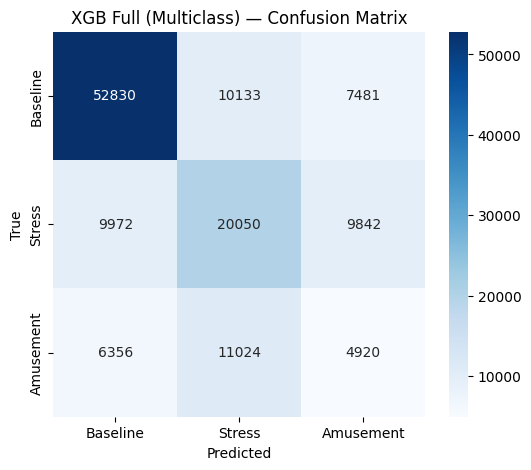


=== XGB Wrist (Multiclass) ===
Subject-macro: {'accuracy': 0.6217, 'precision': 0.5368, 'recall': 0.559, 'f1': 0.528}
Pooled: {'accuracy': np.float64(0.6219)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
10      S5  0.732860   0.549146  0.578575  0.560946
2      S13  0.710018   0.640730  0.632624  0.636005
9       S4  0.708776   0.504833  0.556635  0.527899
13      S8  0.687076   0.556660  0.542145  0.545087
12      S7  0.685055   0.731663  0.686492  0.654437


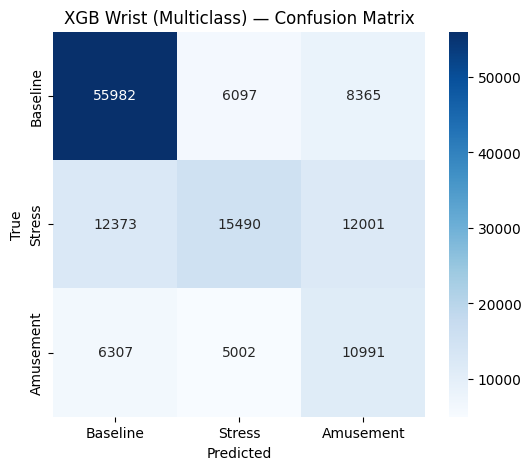


=== XGB Chest (Multiclass) ===
Subject-macro: {'accuracy': 0.5193, 'precision': 0.4285, 'recall': 0.4595, 'f1': 0.3853}
Pooled: {'accuracy': np.float64(0.52)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
4      S15  0.829713   0.633702  0.667082  0.604577
5      S16  0.787821   0.582015  0.615527  0.592144
6      S17  0.642465   0.428157  0.538140  0.470625
11      S6  0.631131   0.484637  0.542302  0.465024
2      S13  0.622305   0.568715  0.566833  0.565939


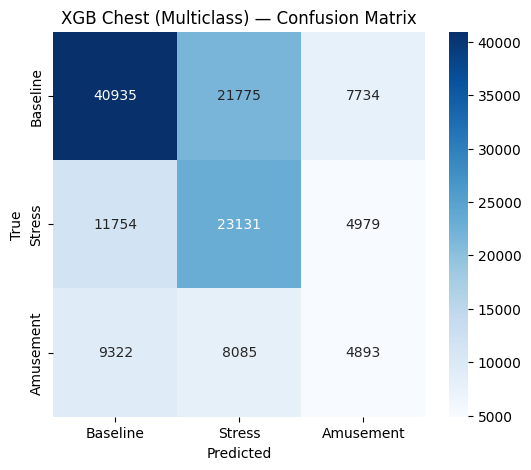


=== XGB Full (Binary) ===
Subject-macro: {'accuracy': 0.6991, 'precision': 0.4954, 'recall': 0.4878, 'f1': 0.4543}
Pooled: {'accuracy': np.float64(0.6999), 'precision': np.float64(0.5008), 'recall': np.float64(0.486), 'f1': np.float64(0.4933)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
4      S15  0.991603   0.991891  0.980685  0.986256
9       S4  0.889954   1.000000  0.624803  0.769082
10      S5  0.878439   0.734248  0.912403  0.813688
3      S14  0.827907   0.664970  0.871111  0.754209
2      S13  0.804133   0.644304  0.766566  0.700138


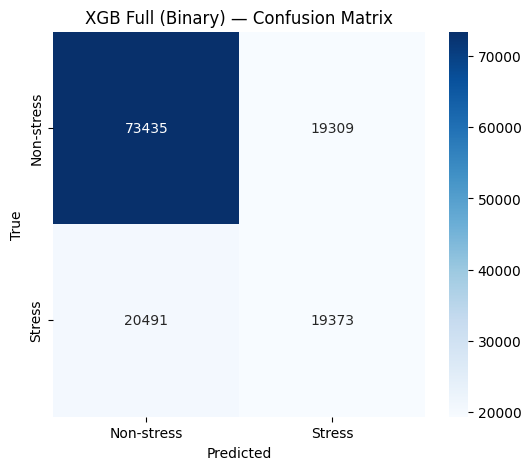


=== XGB Wrist (Binary) ===
Subject-macro: {'accuracy': 0.7312, 'precision': 0.5138, 'recall': 0.6323, 'f1': 0.564}
Pooled: {'accuracy': np.float64(0.7327), 'precision': np.float64(0.5476), 'recall': np.float64(0.638), 'f1': np.float64(0.5893)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
12      S7  0.980551   0.937386  1.000000  0.967681
2      S13  0.958558   0.878017  1.000000  0.935047
13      S8  0.948393   0.854592  1.000000  0.921596
0      S10  0.928854   0.818619  0.997586  0.899285
10      S5  0.920388   0.785149  1.000000  0.879645


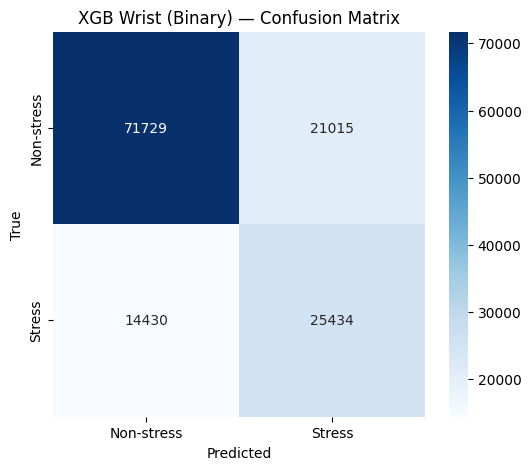


=== XGB Chest (Binary) ===
Subject-macro: {'accuracy': 0.7083, 'precision': 0.5507, 'recall': 0.6804, 'f1': 0.5393}
Pooled: {'accuracy': np.float64(0.7098), 'precision': np.float64(0.513), 'recall': np.float64(0.6839), 'f1': np.float64(0.5862)}
Top-5 subjects:
   subject  accuracy  precision    recall        f1
4     S15  1.000000   1.000000  1.000000  1.000000
5     S16  0.962404   1.000000  0.875929  0.933861
6     S17  0.921134   0.801108  1.000000  0.889572
2     S13  0.884097   0.859292  0.731175  0.790073
1     S11  0.871185   0.833900  0.721691  0.773749


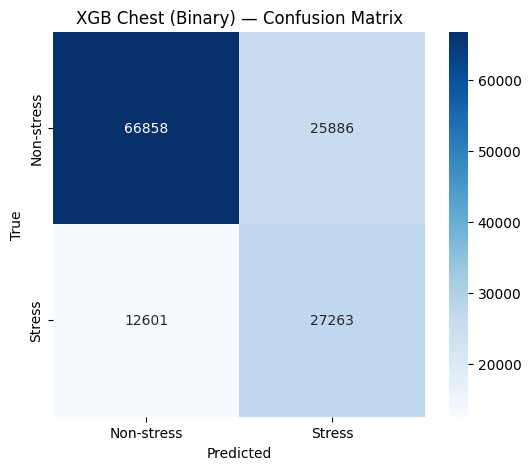

In [39]:
#performance metrics and confusion matrix
def plot_cm(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
    
def show_result(name, per_sub, summary, cm, labels):
    print(f"\n=== {name} ===")
    print("Subject-macro:", {k: round(v,4) for k,v in summary.items()})
    acc = cm.trace() / cm.sum()
    # compute pooled precision/recall/f1 for binary; for multi we report accuracy as pooled
    if len(labels) == 2:
        tn, fp, fn, tp = cm.ravel()
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        pooled = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    else:
        pooled = {"accuracy": acc}
    print("Pooled:", {k: round(v,4) for k,v in pooled.items()})
    print("Top-5 subjects:\n", per_sub.sort_values("accuracy", ascending=False).head(5))
    plot_cm(cm, labels, f"{name} — Confusion Matrix")

# MULTICLASS
show_result("XGB Full (Multiclass)",  ps_xgb_full_m,  sm_xgb_full_m,  cm_xgb_full_m,  labels_mc)
show_result("XGB Wrist (Multiclass)", ps_xgb_wrist_m, sm_xgb_wrist_m, cm_xgb_wrist_m, labels_mc)
show_result("XGB Chest (Multiclass)", ps_xgb_chest_m, sm_xgb_chest_m, cm_xgb_chest_m, labels_mc)

# BINARY
show_result("XGB Full (Binary)",  ps_xgb_full_b,  sm_xgb_full_b,  cm_xgb_full_b,  labels_bi)
show_result("XGB Wrist (Binary)", ps_xgb_wrist_b, sm_xgb_wrist_b, cm_xgb_wrist_b, labels_bi)
show_result("XGB Chest (Binary)", ps_xgb_chest_b, sm_xgb_chest_b, cm_xgb_chest_b, labels_bi)

In [45]:
def loso_mean_importance_xgb(X, y, g, feature_names, best_params, task="multi"):
    """
    Refit LOSO with fixed best_params, return mean gain importance Series.
    """
    logo = LeaveOneGroupOut()
    importances = []

    for tr, te in logo.split(X, y, g):
        if task == "binary":
            pos, neg = (y[tr]==1).sum(), (y[tr]==0).sum()
            spw = (neg / max(pos,1)) if pos > 0 else 1.0
            clf = XGBClassifier(
                objective="binary:logistic", eval_metric="logloss",
                tree_method="hist", scale_pos_weight=spw,
                random_state=42, n_jobs=-1, **best_params
            )
        else:
            clf = XGBClassifier(
                objective="multi:softprob", num_class=3, eval_metric="mlogloss",
                tree_method="hist", random_state=42, n_jobs=-1, **best_params
            )

        # train
        clf.fit(pd.DataFrame(X[tr], columns=feature_names), y[tr])

        # map importance keys
        gain = clf.get_booster().get_score(importance_type="gain")
        if gain and all(k.startswith("f") for k in gain.keys()):
            gain = {feature_names[int(k[1:])]: v for k, v in gain.items()}
        importances.append(pd.Series(gain).reindex(feature_names).fillna(0.0))

    return pd.concat(importances, axis=1).mean(axis=1).sort_values(ascending=False)

def plot_top_imp(imp: pd.Series, title, top=15):
    """Bar plot of top-k features from importance Series."""
    s = imp.head(top)[::-1]  # reverse for nicer barh
    plt.figure(figsize=(8,6))
    plt.barh(s.index, s.values)
    plt.title(title)
    plt.xlabel("Mean gain importance (LOSO)")
    plt.tight_layout()
    plt.show()

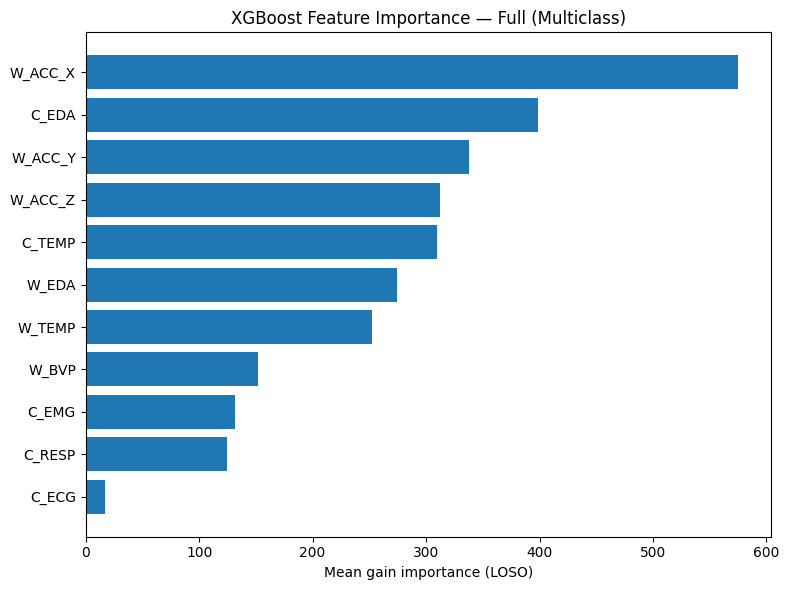

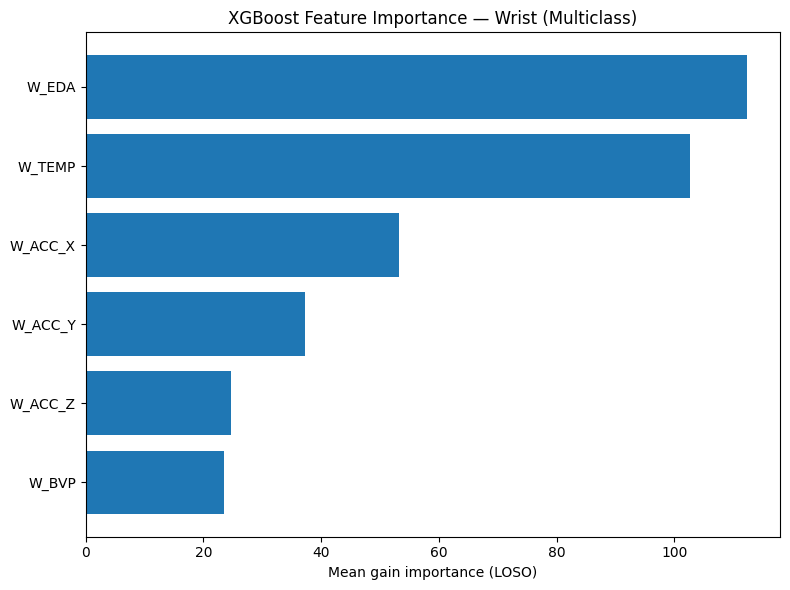

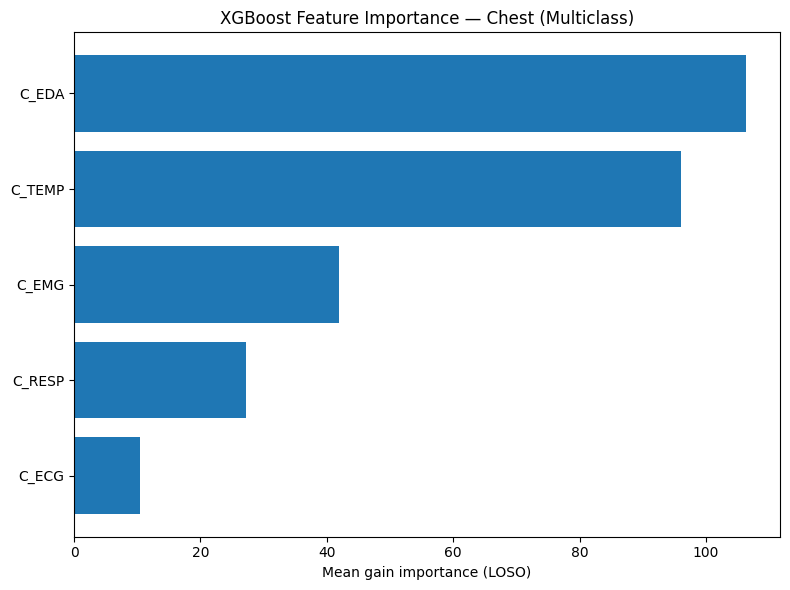

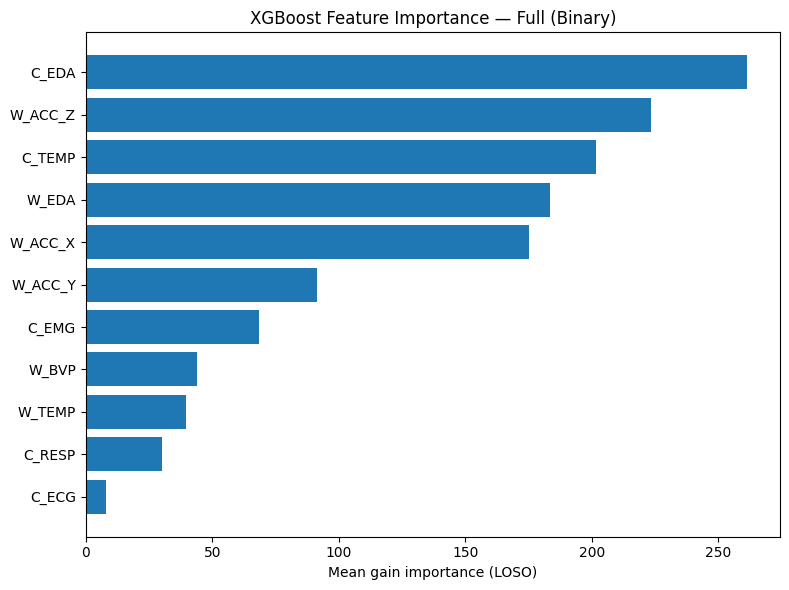

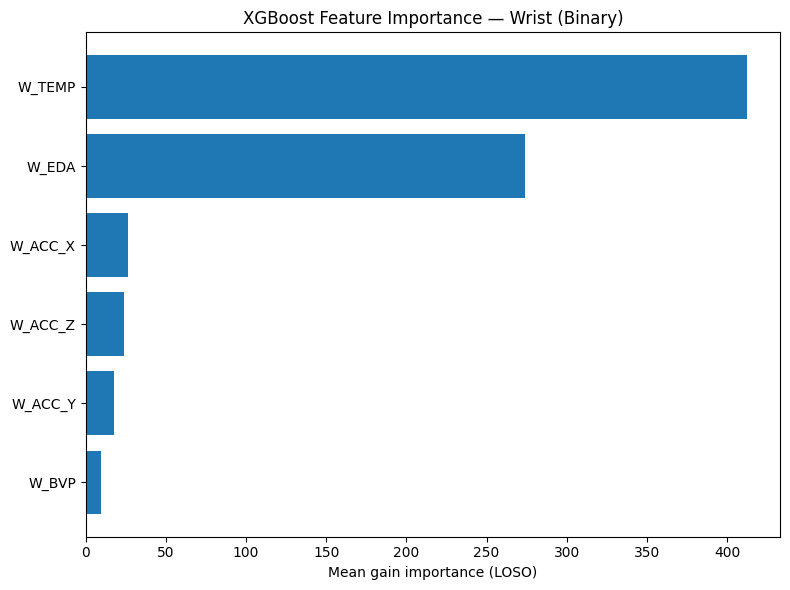

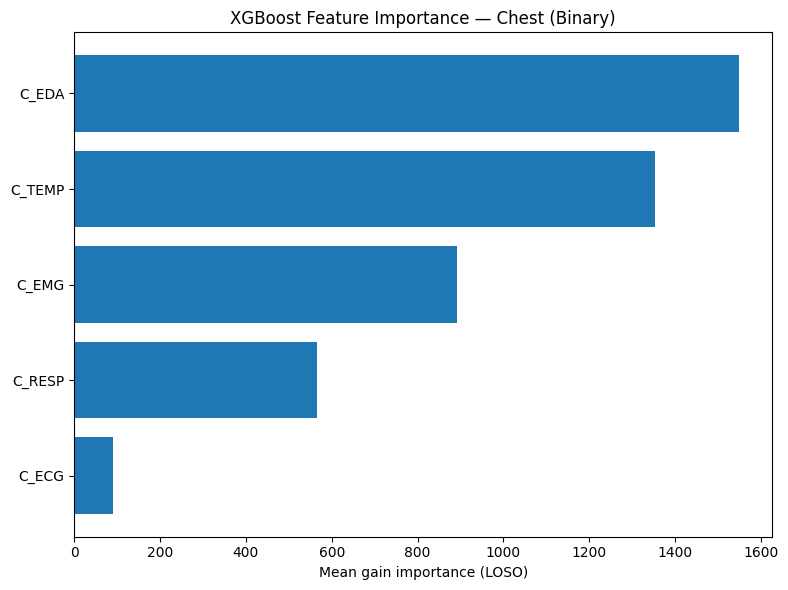

In [46]:
#Feature importance
#MULTICLASS 
imp_full_m  = loso_mean_importance_xgb(X3_full,  y3, g3, FEATURES,   bp_xgb_full_m,  task="multi")
imp_wrist_m = loso_mean_importance_xgb(X3_wrist, y3, g3, WRIST_COLS, bp_xgb_wrist_m, task="multi")
imp_chest_m = loso_mean_importance_xgb(X3_chest, y3, g3, CHEST_COLS, bp_xgb_chest_m, task="multi")

plot_top_imp(imp_full_m,  "XGBoost Feature Importance — Full (Multiclass)")
plot_top_imp(imp_wrist_m, "XGBoost Feature Importance — Wrist (Multiclass)")
plot_top_imp(imp_chest_m, "XGBoost Feature Importance — Chest (Multiclass)")

#BINARY
imp_full_b  = loso_mean_importance_xgb(Xb_full,  yb, gb, FEATURES,   bp_xgb_full_b,  task="binary")
imp_wrist_b = loso_mean_importance_xgb(Xb_wrist, yb, gb, WRIST_COLS, bp_xgb_wrist_b, task="binary")
imp_chest_b = loso_mean_importance_xgb(Xb_chest, yb, gb, CHEST_COLS, bp_xgb_chest_b, task="binary")

plot_top_imp(imp_full_b,  "XGBoost Feature Importance — Full (Binary)")
plot_top_imp(imp_wrist_b, "XGBoost Feature Importance — Wrist (Binary)")
plot_top_imp(imp_chest_b, "XGBoost Feature Importance — Chest (Binary)")